In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='~/Code/dataset/CIFAR10', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/Code/dataset/CIFAR10', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, num_workers=2, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

552/170498071 [01:50<03:33, 455284.31it/s]
100%|█████████▉| 170409984/170498071 [03:47<00:00, 345392.80it/s]Extracting /Users/arthur/Code/dataset/CIFAR10/cifar-10-python.tar.gz to /Users/arthur/Code/dataset/CIFAR10
Files already downloaded and verified


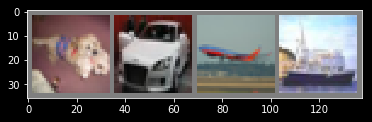

dog   car plane  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0
    
    print('Finished Training')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.862
[1,  6000] loss: 1.686
[1,  8000] loss: 1.568
[1, 10000] loss: 1.515
[1, 12000] loss: 1.433
Finished Training
[2,  2000] loss: 1.359
[2,  4000] loss: 1.353
[2,  6000] loss: 1.339
[2,  8000] loss: 1.314
[2, 10000] loss: 1.289
[2, 12000] loss: 1.251
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

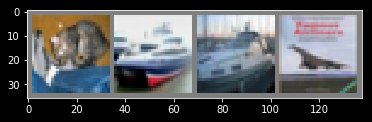

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 63 %
Accuracy of  bird : 38 %
Accuracy of   cat : 34 %
Accuracy of  deer : 48 %
Accuracy of   dog : 56 %
Accuracy of  frog : 70 %
Accuracy of horse : 64 %
Accuracy of  ship : 61 %
Accuracy of truck : 65 %


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")